In [1]:
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
import torch
import chess.pgn
from stockfish import Stockfish
import sqlite3
import chess
import graphviz
import chess.polyglot

In [2]:
torch.cuda.set_device(0)
device = torch.device('cuda')
loss_function = nn.MSELoss()

In [3]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(384, 16),
            nn.ReLU(),
            nn.Linear(16, 16),
            nn.ReLU(),
            nn.Linear(16, 1),
        )
    def forward(self, x):
        return self.layers(x)

In [4]:
# model = Model()
model = torch.load("yw.pt")
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
model.to(device)

Model(
  (layers): Sequential(
    (0): Linear(in_features=384, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=1, bias=True)
  )
)

In [5]:
def fen_to_bitboard(fen):
    f = torch.zeros((6, 64))
    board = chess.Board(fen)
    if board.turn == chess.WHITE:
        a = 1
        b = -1
    if board.turn == chess.BLACK:
        a = -1
        b = 1
    f[0][list(board.pieces(chess.PAWN, chess.WHITE))] = a
    f[1][list(board.pieces(chess.KNIGHT, chess.WHITE))] = a
    f[2][list(board.pieces(chess.ROOK, chess.WHITE))] = a
    f[3][list(board.pieces(chess.BISHOP, chess.WHITE))] = a
    f[4][list(board.pieces(chess.QUEEN, chess.WHITE))] = a
    f[5][list(board.pieces(chess.KING, chess.WHITE))] = a
    
    f[0][list(board.pieces(chess.PAWN, chess.BLACK))] = b
    f[1][list(board.pieces(chess.KNIGHT, chess.BLACK))] = b
    f[2][list(board.pieces(chess.ROOK, chess.BLACK))] = b
    f[3][list(board.pieces(chess.BISHOP, chess.BLACK))] = b
    f[4][list(board.pieces(chess.QUEEN, chess.BLACK))] = b
    f[5][list(board.pieces(chess.KING, chess.BLACK))] = b
    
    return f.view(1, 384)

In [91]:
con = sqlite3.connect('test.db')
cur = con.cursor()

In [9]:
def fen_to_zobrist(fen):
    f = torch.zeros(1, 64)
    board = chess.Board(fen)
    for i, val in enumerate(list('{0:0b}'.format(chess.polyglot.zobrist_hash(board)))):
        if val == "1":
            f[0][i] = 1
    return f

In [12]:
size = 1000000
# training dataset
fens_ = cur.execute(f"SELECT fen FROM evaluations LIMIT {size}")
fens = fens_.fetchall()
board = chess.Board()
tensors = []
tensors = [fen_to_zobrist(fens[i][0]) for i in range(size)]
bits = torch.cat(tensors, dim=0)
with open('johnZobrist.npy', 'wb') as f:
    np.save(f, bits)

# evals_ = cur.execute(f"SELECT eval FROM evaluations LIMIT {size}")
# evals = evals_.fetchall()
# temp = [((np.arctan(1/2 * evals[i][0]) + np.pi/2)/(np.pi)) for i in range(size)]
# evaluations = torch.tensor(temp, dtype=torch.float32)
# with open('labels.npy', 'wb') as f:
#     np.save(f, evaluations)


# evaluation dataset
# eval_size = 10000
# e_fen_ = cur.execute(f"SELECT fen FROM evaluations WHERE id > {size} LIMIT {eval_size}")
# e_fen = e_fen_.fetchall()
# tensors = [fen_to_bitboard(e_fen[i][0]) for i in range(eval_size)]
# bits = torch.cat(tensors, dim=0)
# with open('eval_examples.npy', 'wb') as f:
#     np.save(f, bits)

# evaluation_ = cur.execute(f"SELECT eval FROM evaluations WHERE id > {size} LIMIT {eval_size}")
# evaluation = evaluation_.fetchall()
# temp = [((np.arctan(1/2 * evaluation[i][0]) + np.pi/2)/(np.pi)) for i in range(eval_size)]
# evaluations = torch.tensor(temp)
# with open('eval_labels.npy', 'wb') as f:
#     np.save(f, evaluations)

# plt.style.use('_mpl-gallery')

# # make data
# np.random.seed(1)

# # plot:
# fig, ax = plt.subplots()

# ax.hist(x, bins=100, linewidth=0.5, edgecolor="white")

# ax.set(xlim=(-2, 2), xticks=np.arange(1, 1),
#        ylim=(0, 1000), yticks=np.linspace(0, 1000, 9))

# plt.show()

In [5]:
losses = []
# eval_losses = []

bits = torch.from_numpy(np.load("bits384.npy")).to(device)
labels = torch.from_numpy(np.load("labels.npy")).to(device)

# eval_examples = torch.from_numpy(np.load("eval_examples.npy")).to(device)
# eval_labels = torch.from_numpy(np.load("eval_labels.npy")).to(device)

In [9]:
# model training
# https://stackoverflow.com/questions/45113245/how-to-get-mini-batches-in-pytorch-in-a-clean-and-efficient-way
n_epochs = 100 # or whatever
batch_size = 128 # or whatever

for epoch in range(n_epochs):
    # X is a torch Variable
    permutation = torch.randperm(bits.size()[0])
#     eval_permutation = torch.randperm(bits.size()[0])
#     for i in range(0, eval_examples.size()[0], batch_size):
#         indices = eval_permutation[i:i+batch_size]
#         batch_x, batch_y = bits[indices], labels[indices]
#         outputs = model(batch_x)
        
#         loss = loss_function(outputs, batch_y.view(-1, 1))
#         eval_losses.append(loss.item())
        
    for i in range(0, bits.size()[0], batch_size):
        optimizer.zero_grad()

        indices = permutation[i:i+batch_size]
        batch_x, batch_y = bits[indices], labels[indices]
        
        outputs = model(batch_x)
        loss = loss_function(outputs, batch_y.view(-1, 1))
        losses.append(loss.item())

        loss.backward()
        optimizer.step()

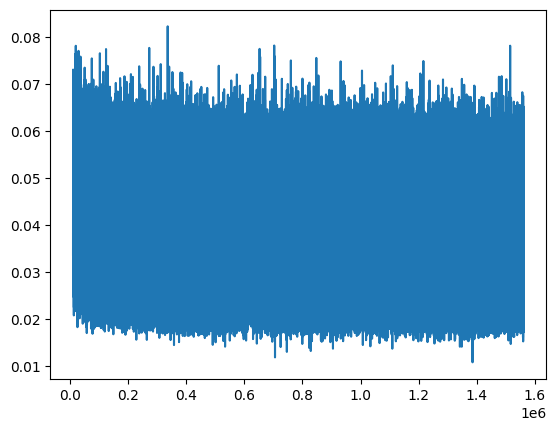

In [11]:
start = 10000
smooth = 1

x = np.arange(len(losses)/smooth)
y = torch.tensor(losses).view(smooth, -1).mean(0)
plt.plot(x[start:], y[start:])

# e_x = np.arange(0, (len(eval_losses)/smooth) * 100, 100)
# e_y = torch.tensor(eval_losses).view(smooth, -1).mean(0)
# plt.plot(e_x[int(start/100):], e_y[int(start/100):])

# plt.ylim(0, 0.005)
plt.show()

In [12]:
sum(losses[len(losses) - 100:]) / 100

0.03542631553485989

tensor(0.)
tensor(7.3181)


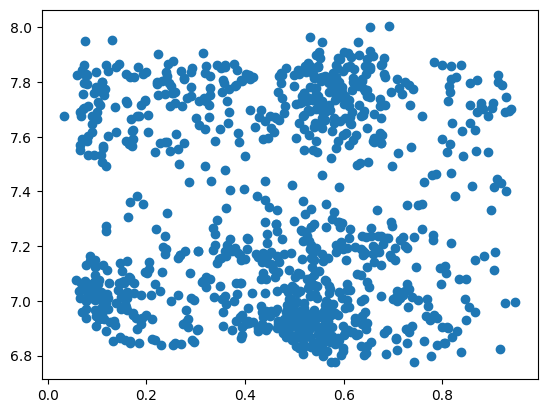

In [233]:
size = 1000
# training dataset
fens_ = cur.execute(f"SELECT fen FROM evaluations LIMIT {size}")
fens = fens_.fetchall()

# print(model(a))
w = list(model.parameters())
w1 = torch.floor(torch.clip((w[0].detach().cpu() / 0.5) + 7.5, 0, 15))
w2 = torch.floor(torch.clip(w[2].detach().cpu() / 0.25 + 7.5, 0, 15))
w3 = torch.floor(torch.clip(w[4].detach().cpu() / 0.0125 + 7.5, 0, 15))
# b = torch.tensor([0.5235], device=device)
# w1 = (torch.floor((w*90.2425267908)+6.7241))
# # relu = torch.nn.ReLU()
# L = []
# for i in w1.int():
#     L.append(i.item())
# print(L)
real = []
quant = []
quants = 0
quantz = 0
for i in range(1000):
    fen = fens[i][0]
    a = fen_to_bitboard(fen)
    # real
    relu = nn.ReLU()
    r = (a @ w[0].T.detach().cpu() + w[1].detach().cpu())
    r = relu(r)
    r = (r @ w[2].T.detach().cpu() + w[3].detach().cpu())
    r = relu(r)
    r = (r @ w[4].T.detach().cpu() + w[5].detach().cpu())

    # quant
    q = (a @ (w1.T - 7.5) + (w[1].detach().cpu()/0.5).int()) #* 0.5/1.0669375 + 0.9923 + 7.5
    q = torch.clamp(q, 0, 15)
    q = (q @ (w2.T - 7.5) + (w[3].detach().cpu().int()/0.25).int()) * 0.25/4.15195625 + 8.1350 + 7.5
    q = torch.clamp(q, 0, 15)
    q = (q @ (w3.T - 7.5) + (w[5].detach().cpu().int()/0.0125).int()) * 0.0125/1 + 7.5
    real.append(r.item())
    quant.append(q.item())
    quants += -torch.min(q)+torch.max(q)
    quantz += (torch.min(q)+torch.max(q))/2
plt.scatter(real, quant)
# plt.hist(q.view(1, -1), 10)
print(quants/1000)
print(quantz/1000)
#     plt.hist(r, 100)

# print(r)
# print(q)
# print(((a @ w1) - (6.7241 * torch.sum(a)))/90.2425267908)

In [119]:
'{0:04b}'.format(15)

'1111'

In [126]:
W = []
for pog in range(48):
    str = ""
    for peepo in L[pog:pog+16]:
        str += '{0:04b}'.format(peepo)
#     print(str)
    W.append(int(str, 2))
print(W)

[4856156134427813478, 3911521856006809191, 7244117474980292214, 5225415157427365733, 9819666223999645270, 9540706994317911399, 5077359319410169463, 7450772815724504950, 8531900609334769510, 7383201233389450855, 7450755291973903991, 8531620229325154166, 7378715153235605351, 7378978009512375926, 7383183709940705125, 7450474916793972310, 8527134226446247271, 7306939107173095032, 6230561272512210823, 7455259991647615093, 8603695424104531799, 8531918269705647478, 7383483799323498343, 7455276346918663801, 8603957108441311126, 8536105219094116710, 7450474989539006053, 8527135390366787158, 7306957729901733220, 6230859236170421828, 7460027410178991172, 8679974120606549061, 9752377413737923670, 8464086030130365798, 6298167966118991459, 8536967089356105270, 7464264913730823015, 8747774177435858551, 10837178323006875506, 7374156504724043560, 7306039633327387269, 6216169690980886616, 7224994687146427781, 4919450552085534807, 4924232538530350454, 5000744321647400804, 6224932851520206409, 73652052557

In [115]:
abd = '{0:064b}'.format(100000)
len(abd)

64

In [45]:
def evaluation(fen):
    model.eval()
    score  = model(fen_to_bitboard(fen).to(device))
    model.train()
    return score.item()

In [7]:
class Node():
    def __init__(self, fen, parent, color, move):
        self.fen = fen
        self.parent = parent
        self.children = None
        self.visits = 0
        self.prior = 0
        self.wins = 0
        self.color = color
        self.move = move

In [9]:
def minimax(board, depth, alpha, beta):
    moves = list(board.legal_moves)
    if depth == 1:
        tensors = []
        for m in moves:
            board.push(m)
            tensors.append(fen_to_bitboard(board.fen()).to(device))
            board.pop()
        model.eval()
        logits = model(torch.cat(tensors, dim=0))
        model.train()
        if board.turn == chess.WHITE:
            return torch.max(logits).item(), None
        else:
            return torch.min(logits).item(), None
    if board.turn == chess.WHITE:
        maxScore = -1000
        best_move = None
        for m in moves:
            board.push(m)
            score, _ = minimax(board, depth-1, alpha, beta)
            if score > maxScore:
                maxScore = score
                best_move = m
            board.pop()
            alpha = max(alpha, score)
            if beta <= alpha:
                break
        if depth < 4:
            return maxScore, None
        if depth == 4:
            return maxScore, best_move
    else:
        minScore = 1000
        best_move = None
        for m in moves:
            board.push(m)
            score, _ = minimax(board, depth-1, alpha, beta)
            if score < minScore:
                minScore = score
                best_move = m
            board.pop()
            beta = min(beta, score)
            if beta <= alpha:
                break
        if depth < 4:
            return minScore, None
        if depth == 4:
            return minScore, best_move

In [131]:
def expand_node(node, color):
    board = chess.Board(node.fen)
    moves = list(board.legal_moves)
    nodes = []
    
    tensors = []

    for move in moves:
        board.push(move)
        n = Node(board.fen(), node, board.turn, move)
        nodes.append(n)
        tensors.append(fen_to_bitboard(n.fen).to(device))
        board.pop()

    node.children = nodes
    
    if len(node.children) > 0:
        model.eval()
        logits = model(torch.cat(tensors, dim=0))
        
        if node.color == False:
            for i, child in enumerate(node.children):
                child.prior = (1 - logits[i].item())
            return float(1 - sum(logits) / len(logits))
        else:
            for i, child in enumerate(node.children):
                child.prior = (logits[i].item())
            return float(sum(logits) / len(logits))
        model.train()

def select_child(node):
    best_node = None
    
    best = -np.inf
    for child in node.children:
        if child.visits > 0:
            val = child.wins / child.visits + np.sqrt(2) * np.sqrt(np.log(node.visits) / (child.visits))
        else:
            val = child.prior + np.sqrt(2) * np.sqrt(np.log(node.visits) / (child.visits + 1))
#         print(f"{child.move} {child.visits} {child.prior:.3f} {child.wins:.3f} {val:.4f} {node.visits}")
        if val > best:
            best = val
            best_node = child
    
#     print(best_node.move)
    return best_node

def backpropagate(node, score, color):
    while node is not None:
        node.visits += 1
        if color == node.color:
            node.wins += score
        else:
            node.wins += (1 - score)
        node = node.parent

def search(board):
    root = Node(board.fen(), None, board.turn, None)

    for _ in range(1000):
        # Selection and expansion
        current = root
        while current.children is not None:
            current = select_child(current)
#         print()

        if current.visits == 0:
            # If the node has not been visited yet, expand it
            score = expand_node(current, current.color)

        # Simulation
        score = current.prior

        # Backpropagation
        backpropagate(current, score, current.color)

    # Choose the best move based on visits
    best_visits = -1
    best_move = ""

    for node in root.children:
        print(f"{node.move} {node.visits} {node.prior:.3f} {node.wins:.3f} {(node.wins/(node.visits)):.4f}")
        if node.visits > best_visits:
            best_visits = node.visits
            best_move = node.move
    
    return best_move

In [132]:
fen = "r1bqkb1r/pppp1ppp/2n2n2/4p3/2B1P3/3P1N2/PPP2PPP/RNBQK2R b KQkq - 0 4"
board = chess.Board(fen)
# print(minimax(board, 4, -1000000, 1000000))
search(board)

h8g8 27 0.259 11.112 0.4116
f8e7 38 0.407 19.795 0.5209
f8d6 31 0.369 14.227 0.4589
f8c5 38 0.448 19.967 0.5254
f8b4 29 0.421 12.479 0.4303
f8a3 33 0.374 15.699 0.4757
e8e7 22 0.253 7.216 0.3280
d8e7 28 0.341 11.821 0.4222
a8b8 29 0.345 12.717 0.4385
f6g8 26 0.292 10.107 0.3887
f6h5 30 0.332 13.336 0.4445
f6d5 22 0.178 7.280 0.3309
f6g4 30 0.310 13.393 0.4464
f6e4 76 0.428 53.398 0.7026
c6b8 25 0.247 9.324 0.3730
c6e7 24 0.225 8.710 0.3629
c6a5 38 0.358 19.897 0.5236
c6d4 31 0.260 14.284 0.4608
c6b4 30 0.279 13.434 0.4478
h7h6 36 0.425 18.279 0.5078
g7g6 28 0.285 11.779 0.4207
d7d6 34 0.387 16.512 0.4856
b7b6 27 0.295 11.097 0.4110
a7a6 31 0.415 14.282 0.4607
h7h5 26 0.290 10.174 0.3913
g7g5 24 0.238 8.689 0.3621
d7d5 104 0.346 79.398 0.7634
b7b5 50 0.364 30.130 0.6026
a7a5 32 0.354 14.934 0.4667


Move.from_uci('d7d5')

In [28]:
# white
fen = "8/8/8/KP1q1k2/P7/8/8/8 w - - 1 61"
board = chess.Board(fen)
moves = list(board.legal_moves)

scores = []
best_score = -1000
best_move = ""
for m in moves:
    board.push(m)
    score = evaluation(board.fen())
    scores.append(score)
    print(str(score) + " " + str(m))
    if score > best_score:
        best_score = score
        best_move = m
    board.pop()
print(best_move)
print(sum(scores) / len(scores))

-0.04337083548307419 a5b6
-0.03220266103744507 a5a6
-0.04406551271677017 a5b4
a5a6
-0.039879669745763145


In [130]:
# black
fen = "r1bqk2r/pppp1ppp/2n2n2/2b1p3/2B1P3/3P1N1P/PPP2PP1/RNBQK2R b KQkq - 0 5"
board = chess.Board(fen)
moves = list(board.legal_moves)

scores = []
best_score = 1000
best_move = ""
for m in moves:
    board.push(m)
    score = evaluation(board.fen())
    scores.append(score)
    print(str(score) + " " + str(m))
    if score < best_score:
        best_score = score
        best_move = m
    board.pop()
print(best_move)
print(1 - sum(scores) / len(scores))

0.6949711441993713 h8g8
0.5791548490524292 h8f8
0.6526648998260498 e8f8
0.6621037721633911 e8e7
0.5586944818496704 d8e7
0.596760094165802 a8b8
0.6642712354660034 f6g8
0.5706773400306702 f6h5
0.7545305490493774 f6d5
0.6737837195396423 f6g4
0.35478276014328003 f6e4
0.7026157379150391 c6b8
0.7306617498397827 c6e7
0.6152477264404297 c6a5
0.6482574939727783 c6d4
0.7644238471984863 c6b4
0.7152622938156128 c5f8
0.6191264390945435 c5e7
0.6805263161659241 c5d6
0.5572850108146667 c5b6
0.604566752910614 c5d4
0.5946999192237854 c5b4
0.6883387565612793 c5e3
0.6837028861045837 c5a3
0.747037410736084 c5f2
0.5310772061347961 e8g8
0.5426334738731384 h7h6
0.6632850170135498 g7g6
0.5449357032775879 d7d6
0.6223488450050354 b7b6
0.5728025436401367 a7a6
0.6837194561958313 h7h5
0.6673473119735718 g7g5
0.5923116207122803 d7d5
0.5635175108909607 b7b5
0.5908156633377075 a7a5
f6e4
0.3697516239351697


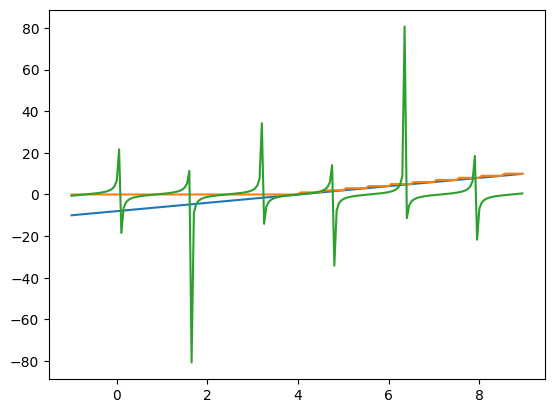

In [39]:
x = np.arange(-1, 9, .05)
y = np.arange(-10, 10, .1)
plt.plot(x, y)
y = [np.ceil(max(0, i)) for i in y]
plt.plot(x, y)
x = np.arange(-1, 9, .05)
y = np.arange(-10, 10, .1)
y = [np.tan(i) for i in y]
plt.plot(x, y)